In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import scipy.signal
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize, downscale_local_mean
import csv

In [2]:
path = '/srv/home/chenyu/DEbackup/2019/012119/S4/'  # Same dataset can be found in experiment data package
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(150,150))

(-0.5, 149.5, 149.5, -0.5)

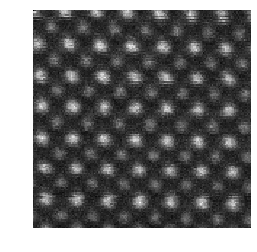

In [3]:
peaks_x = np.load(path + 'SrPeaks_x.npy')
peaks_y = np.load(path + 'SrPeaks_y.npy')
plt.imshow(HAADFarray,cmap='gray')
# plt.scatter(peaks_x,peaks_y,c='r')
plt.axis('off')

24.0


(-0.5, 511.5, 511.5, -0.5)

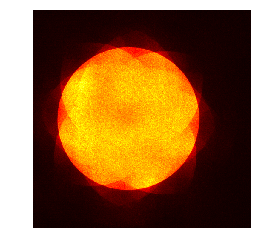

In [4]:
PACBED_stack = np.load(path + 'PACBED_stack_radius_7.npy')
plt.imshow(PACBED_stack[:,:,10],cmap='hot')
plt.clim([np.amin(PACBED_stack[:,:,10]),np.amax(PACBED_stack[:,:,10])*1.2])
thickness = np.load(path + 'SrPeaks_thickness.npy')
print(thickness[10])
plt.axis('off')

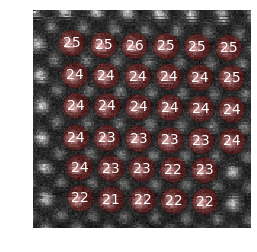

In [5]:
peaks_x = np.load(path + 'SrPeaks_x.npy')
peaks_y = np.load(path + 'SrPeaks_y.npy')
prediction = np.load(path + 'prediction.npy')
plt.imshow(HAADFarray,cmap = 'gray')
plt.axis('off')
for i in range(peaks_x.shape[0]):
    plt.text(peaks_x[i]-4, peaks_y[i]+2, int(prediction[i]/0.3905), bbox=dict(boxstyle='circle',facecolor='red', alpha=0.2)
             ,fontsize=14,color='white')

## To reply reviewer's comments and generate PACBED from in between area

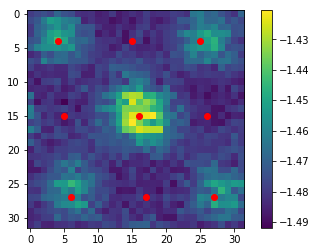

In [37]:
# Select one single unit cell for PACBED, mark all the positions of Sr, Ti, and O
plt.imshow(HAADFarray[8:40,8:40])
plt.colorbar()
peak_positions = np.array([[16,15],[4,4],[6,27],[25,4],[27,27],[5,15],[15,4],[26,15],[17,27]])
plt.scatter(peak_positions[:,0],peak_positions[:,1],color='r')

(-0.5, 31.5, 31.5, -0.5)

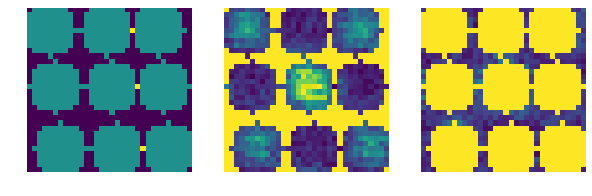

In [45]:
# Create a mask for each atom site and thus get the mask for in between region
expMask = np.zeros((32,32))
for i in range(len(peak_positions)):
    expMask = expMask + create_circular_mask(32,32,center = peak_positions[i,:], radius = 5)
    
    
fig = plt.figure(figsize=(10,6))
fig.add_subplot(131)
plt.imshow(expMask)
plt.axis('off')
fig.add_subplot(132)
plt.imshow((expMask * HAADFarray[8:40,8:40]),clim=[-1.49,-1.42])
plt.axis('off')
fig.add_subplot(133)
plt.imshow((1-expMask) * HAADFarray[8:40,8:40],clim=[-1.49,-1.42])
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

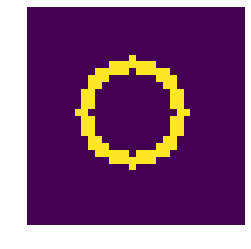

In [89]:
plt.imshow(expMask)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

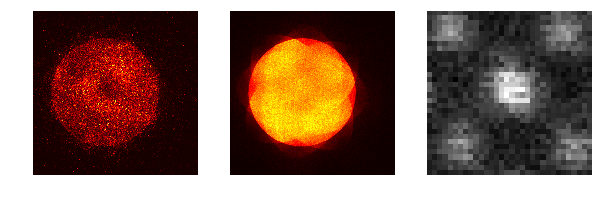

In [88]:
# Collect PACBED from in between region around Sr
expMask = create_circular_mask(32,32,center = [15,15], radius = 8) & ~create_circular_mask(32,32,center = [15,15], radius = 6)
PACBED = np.zeros((512,512))
px_list = np.nonzero(expMask)
row_list = px_list[0] + 8
col_list = px_list[1] + 8
file_list= row_list*150+col_list+1

for ifile in range(file_list.size):
    frame = np.load(path + 'npy/S4_'+format(int(file_list[ifile]),'05')+'.npy')
    PACBED = PACBED + frame

fig = plt.figure(figsize=(10,5))
fig.add_subplot(133)
plt.imshow(HAADFarray[8:40,8:40],cmap='gray')
plt.axis('off')
# fig.add_subplot(224)
# plt.imshow(expMask)
# plt.axis('off')
fig.add_subplot(131)
plt.imshow(CBED,cmap='hot',clim = [np.amin(CBED),np.amax(0.8*CBED)])
plt.axis('off')
fig.add_subplot(132)
plt.imshow(PACBED,cmap='hot',clim = [np.amin(PACBED),np.amax(PACBED)*1.1])
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

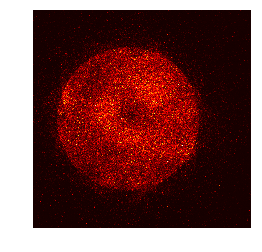

In [75]:
# Collect single CBED from in between region
CBED = np.zeros((512,512))
ifile = 10*150+10+1
CBED = np.load(path + 'npy/S4_'+format(ifile,'05')+'.npy')
plt.imshow(CBED,cmap = 'hot', clim = [np.amin(CBED),np.amax(0.8*CBED)])
plt.axis('off')

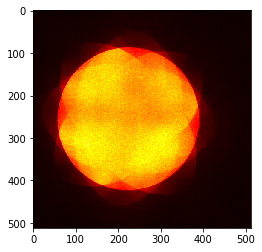

In [51]:
# Generate PACBED based on all the in between mask
PACBED = np.zeros((512,512))
px_list = np.nonzero(1-expMask)
row_list = px_list[0] + 8
col_list = px_list[1] + 8
file_list= row_list*150+col_list+1

for ifile in range(file_list.size):
    frame = np.load(path + 'npy/S4_'+format(int(file_list[ifile]),'05')+'.npy')
    PACBED = PACBED + frame
    
plt.imshow(PACBED,cmap='hot',clim = [np.amin(PACBED),np.amax(PACBED)*1.2])

In [27]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask